In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io as scio
import folium
from folium.plugins import HeatMap
import math
import bisect
import os
import glob
import json
import torch
from tqdm import tqdm
from tqdm.std import trange
import cv2
import copy

# os.environ["CUDA_VISIBLE_DEVICES"] = '3'

In [5]:
data_root = '../dataset/lane_detection/'
label_csv = 'dataset_refine.csv'
label_csv = os.path.join(data_root, label_csv)
csv_data = pd.read_csv(label_csv, index_col=False) #data frame
csv_data.head(10)

,img,index,img_width,img_height,prob,solid_prob,solid_type,points
0,LB-XL_1656_20131112_163725_rgb_f002900,0,1280,720,1.0,1.0,dashed,"[[80.1280675873611, 720], [82.02811241149902, ..."
1,LB-XL_1656_20131112_163725_rgb_f002900,1,1280,720,1.0,1.0,dashed,"[[1202.6919665481105, 720], [1200.825805664062..."
2,LB-XL_1656_20131112_163725_rgb_f002900,2,1280,720,1.0,1.0,dashed,"[[715.7992379491913, 362.2838052467276], [744...."
3,LB-XL_1656_20131112_163725_rgb_f002900,3,1280,720,1.0,1.0,dashed,"[[1279.9989999999525, 487.6700064695726], [115..."
4,LB-XL_1656_20131112_163725_rgb_f002900,4,1280,720,1.0,1.0,solid,"[[1280, 453.87751399543856], [1253.20816040039..."
5,LB-XL_1656_20131112_163725_rgb_f002900,5,1280,720,1.0,1.0,solid,"[[1279.9989999999525, 414.24438312419227], [10..."
6,LB-XL_1656_20140216_134028_rgb_f004800,0,1280,720,1.0,1.0,solid,"[[0, 470.25173846941686], [7.7619582414627075,..."
7,LB-XL_1656_20140216_134028_rgb_f004800,1,1280,720,1.0,1.0,solid,"[[0, 646.1786319800624], [15.530850887298584, ..."
8,LB-XL_1656_20140216_134028_rgb_f004800,2,1280,720,1.0,1.0,solid,"[[923.4982305765152, 720], [802.8854370117188,..."
9,LB-XL_1656_20140216_134028_rgb_f004800,3,1280,720,1.0,1.0,solid,"[[1279.9989999999525, 516.6155026930857], [127..."


In [4]:
#### V-01-B Create Dataset 
class datasetItem:
    def __init__(self, index):
        self.index = index
        self.global_id = None
        self.img_path = ''
        self.img_shape = None
        self.lanes = []
        self.prob = []
        self.solid_prob = []
        self.solid_type = []

def to_dataset(data, # csv input
               dataset # output
              ):
    file_unreaded = True
    data_item_idx = 0

    print('to create dataset')

    for idx, index in tqdm( enumerate(data['index']) ):
        points = []
        if index == 0 and file_unreaded: # file not readed, first lane of image

            file_unreaded = False
            data_item = datasetItem(data_item_idx)
            # data_item.global_id = data['global_id'][idx]
            data_item.img_path  = data['img'][idx]
            data_item.img_shape = (data['img_width'][idx], data['img_height'][idx])

            data_item.lanes.append(json.loads(data['points'][idx]))
            data_item.prob.append(data['prob'][idx])
            data_item.solid_prob.append(data['solid_prob'][idx])
            data_item.solid_type.append(data['solid_type'][idx])

            dataset.append(data_item) # create new item
            
        elif index == 0 and not file_unreaded: # file readed, first lane of image

            data_item = datasetItem(data_item_idx)
            # data_item.global_id = data['global_id'][idx]
            data_item.img_path  = data['img'][idx]
            data_item.img_shape = (data['img_width'][idx], data['img_height'][idx])

            data_item.lanes.append(json.loads(data['points'][idx]))
            data_item.prob.append(data['prob'][idx])
            data_item.solid_prob.append(data['solid_prob'][idx])
            data_item.solid_type.append(data['solid_type'][idx])

            dataset.append(data_item) # create new item
            
        else: # following lanes of image
            dataset[-1].lanes.append(json.loads(data['points'][idx]))
            dataset[-1].prob.append(data['prob'][idx])
            dataset[-1].solid_prob.append(data['solid_prob'][idx])
            dataset[-1].solid_type.append(data['solid_type'][idx])
    print('done')

In [5]:
#### V-01-B
dataset = []
to_dataset(csv_data, dataset)

584it [00:00, 5839.27it/s]

to create dataset


358162it [00:37, 9620.05it/s] 

done


In [28]:
#### V-01-B
dataset_orig = copy.deepcopy(dataset)
len(dataset)

99999

In [45]:
#### V-01-B Delete&update invalid pt
for daid, it in enumerate(dataset):
    for lid, ln in enumerate(it.lanes):
        del_pid = []
        for pid, pt in enumerate(ln):
            if pt[0] < .0 or pt[1] < .0:
                del_pid.append(pid)
            elif pt[0] >= 1280. or pt[1] >= 720.:
                pt[0] = 1279. if pt[0] >= 1280. else pt[0]
                pt[1] = 719.  if pt[1] >= 720.  else pt[1]
        if len(del_pid) > 0:
            # print(del_pid)
            del ln[ del_pid[0] ]

In [ ]:
#### V-01-B Check
for daid, it in enumerate(dataset):
    for lid, ln in enumerate(it.lanes):
        for x,y in ln:
            if x<.0 or y<.0 or x>=1280. or y >= 720.:
                print(daid, lid, x, y)

[(0, 468), (36, 458), (226, 408), (496, 343), (659, 309)]
[(0, 718), (239, 558), (363, 478), (475, 408), (542, 369), (603, 336), (654, 317), (689, 307)]
[(114, 719), (115, 718), (440, 458), (548, 377), (599, 345), (629, 328), (690, 309)]
[(1122, 719), (1121, 718), (907, 528), (806, 438), (750, 388), (709, 348), (697, 332), (697, 322), (710, 307)]
[(1279, 486), (1255, 478), (1089, 428), (921, 378), (801, 340), (770, 330), (749, 322), (737, 313), (747, 303)]


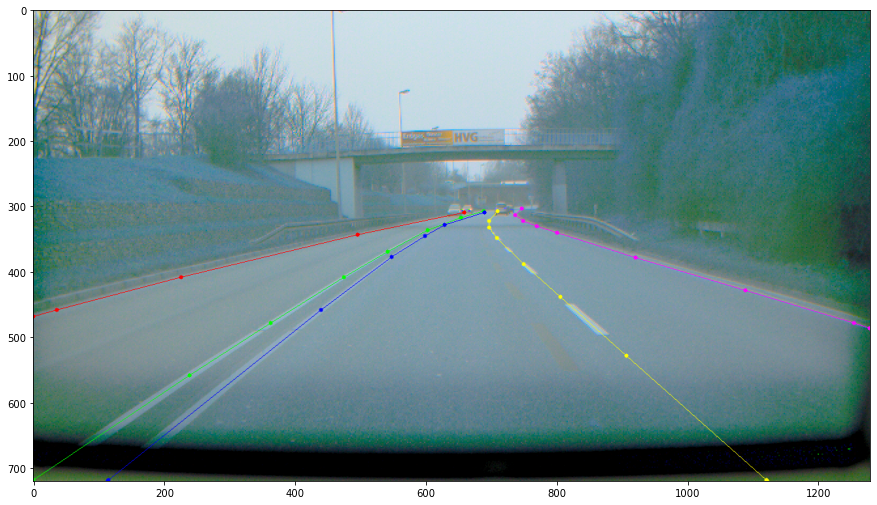

In [47]:
#### V-01-B Show
from tools import spline_interp_step
import matplotlib.pyplot as plt
color = [(255,0,0), (0,255,0),(0,0,255),\
         (255,255,0),(255,0,255),(0,255,255),(255,255,255),\
         (100,255,0),(100,0,255),(255,100,0),(0,100,255),(255,0,100),(0,255,100),(0,0,0)]

tid = 72570            
temp_data_item = dataset[tid]

img_path = os.path.join(data_root, 'images', temp_data_item.img_path+'.bmp')
img = cv2.imread(img_path)
img_cp = copy.deepcopy(img)
for idx, pts in enumerate(temp_data_item.lanes):
    print([(int(pt[0]), int(pt[1])) for pt in pts])
    for i in range(len(pts)-1):
        x1 = int(pts[i][0])
        y1 = int(pts[i][1])
        x2 = int(pts[i+1][0])
        y2 = int(pts[i+1][1])    
        
        cv2.circle(img, (x1,y1), 3, color[idx], -1)
        cv2.circle(img, (x2,y2), 3, color[idx], -1)
        cv2.line(img, (x1,y1), (x2,y2), color[idx], 1)

            
plt.figure(figsize=(15, 15))
plt.imshow(img)
# plt.imshow(img_cp)
plt.show() 

In [49]:
#### V-01-B Json format
print('created dataset')
import torch
import numpy as np
from scipy import interpolate

json_data = []

for it in tqdm( dataset ):
    json_it = {}
    json_it['img_path'] = it.img_path
    json_it['img_shape'] = ( int(it.img_shape[0]), int(it.img_shape[1]) )
    json_it['lanes'] = it.lanes
    json_it['prob'] = it.prob
    json_it['solid_prob'] = it.solid_prob
    json_it['solid_type'] = it.solid_type
    json_data.append(json_it)

created dataset


100%|██████████| 99999/99999 [00:00<00:00, 201262.01it/s]


In [50]:
#### V-01-B Write
print('to save json with orig lanes but del outlier')

with open('../dataset/lane_detection/lane-detection_v01b_for_pinet.json', 'w') as outfile:
    json.dump(json_data, outfile)
    
print('saved json')  

to save json with orig lanes but del outlier
saved json


In [ ]:
import os, glob
import matplotlib.pyplot as plt

In [6]:
#### V-01-B load
with open( os.path.join(data_root, 'lane-detection_v01b_for_pinet.json'), 'r') as json_file:
    ld_data = json.load(json_file)
print('done')

done


In [7]:
len(ld_data)

99999

[(0, 568), (9, 566), (19, 564), (29, 562), (39, 560), (49, 558), (58, 556), (68, 554), (74, 553), (84, 551), (94, 549), (104, 547), (114, 545), (123, 543), (132, 541), (141, 539), (151, 537), (161, 535), (171, 533), (180, 530), (183, 529), (193, 527), (203, 524), (212, 521), (222, 518), (231, 515), (241, 512), (247, 510), (257, 507), (266, 505), (276, 502), (286, 500), (292, 498), (301, 496), (311, 494), (321, 492), (331, 489), (340, 487), (350, 486), (356, 484), (366, 483), (376, 481), (385, 479), (395, 477), (398, 477), (408, 475), (418, 472), (424, 471), (434, 468), (443, 465), (453, 461), (462, 458), (463, 457), (472, 454), (482, 450), (491, 446), (500, 443), (510, 439), (510, 439), (519, 436), (529, 432), (538, 429), (548, 426), (557, 423), (566, 420), (576, 417), (585, 414), (595, 411), (604, 409), (614, 406), (624, 403), (624, 403), (634, 400), (643, 398), (653, 395), (654, 395)]
[(198, 719), (206, 714), (214, 708), (222, 702), (230, 696), (238, 690), (246, 684), (254, 678), (26

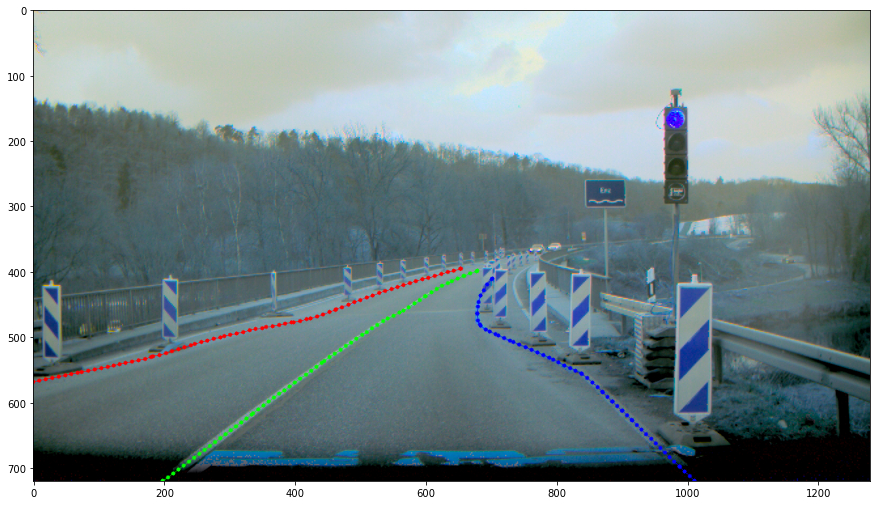

In [10]:
from tools import spline_interp_step
color = [(255,0,0), (0,255,0),(0,0,255),\
         (255,255,0),(255,0,255),(0,255,255),(255,255,255),\
         (100,255,0),(100,0,255),(255,100,0),(0,100,255),(255,0,100),(0,255,100),(0,0,0)]

sample_id = 122
sample_data = ld_data[sample_id]

img_path = os.path.join(data_root, 'images', sample_data['img_path']+'.bmp')
img = cv2.imread(img_path)

for idx, pts in enumerate(sample_data['lanes']):
    
    new_pts = spline_interp_step(pts, 10)
    print([(int(pt[0]), int(pt[1])) for pt in new_pts])
    
    for i in range( len(new_pts)-1 ):
        x1 = int(new_pts[i][0])
        y1 = int(new_pts[i][1])
        x2 = int(new_pts[i+1][0])
        y2 = int(new_pts[i+1][1])    
        
        cv2.circle(img, (x1,y1), 3, color[idx], -1)
        cv2.circle(img, (x2,y2), 3, color[idx], -1)
        cv2.line(img, (x1,y1), (x2,y2), color[idx], 1)

            
plt.figure(figsize=(15, 15))
plt.imshow(img)
plt.show() 